## Trying Brain-score models

### Imports

In [3]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
import torch
import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from sklearn.metrics import mean_squared_error,explained_variance_score
from scipy.stats import pearsonr

'c:\Users\charl\OneDrive' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [ ]:
# Cloning the brain-score github
!git clone https://github.com/brain-score/vision.git
!cd vision
!pip install -e .

from vision.brainscore_vision.models.timm_models import get_model as get_timm_model
from vision.brainscore_vision.models.timm_models.model import MODEL_CONFIGS

c:\Users\charl\OneDrive - Ecole Polytechnique\EPFL\Brain-like intelligence\Exercises\.venv\Lib\site-packages\brainscore_core\metrics\__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


### Load the data and the model

In [4]:
path_to_data = '.' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


In [5]:
model_name = "convnext_large_mlp:clip_laion2b_augreg_ft_in1k_384"   # identifier
model = get_timm_model(model_name) 
layer_names = MODEL_CONFIGS[model_name]["model_commitment"]["layers"]
layer_names 

Model convnext_large_mlp loaded


['stages.2.blocks.4.conv_dw',
 'stages.2.blocks.3',
 'stages.2.blocks.4.conv_dw',
 'stages.2.downsample.1',
 'head.pre_logits']

### Pass the stimulus through the model and fetch the activations

In [6]:
with torch.no_grad():
    activations_val = model.get_activations(stimulus_val, layer_names)

In [9]:
batch_size = 288
activations_list = []

for i in tqdm.tqdm(range(stimulus_train.shape[0] // batch_size)):
    batch = stimulus_train[i * batch_size:(i + 1) * batch_size]
    with torch.no_grad():
        batch_acts = model.get_activations(batch, layer_names)
    activations_list.append(batch_acts)

100%|██████████| 9/9 [10:48<00:00, 72.05s/it]


In [10]:
# Get the keys of activations_val
keys = activations_val.keys()
keys

odict_keys(['stages.2.downsample.1', 'stages.2.blocks.3', 'stages.2.blocks.4.conv_dw', 'head.pre_logits'])

In [11]:
selected_layer = ['stages.2.blocks.3', ]  # pick based on your spike data brain areas

layer_acts_val = {layer: activations_val[layer] for layer in selected_layer}
layer_acts_train = {
    layer: torch.cat(
        [torch.as_tensor(activations_list[i][layer]) for i in range(len(activations_list))],
        dim=0
    )
    for layer in selected_layer
}

In [12]:
# Do a linear regression between the activations and the spikes
X_train = layer_acts_train[selected_layer[0]]
X_val = layer_acts_val[selected_layer[0]]
y_train = spikes_train
y_val = spikes_val

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

### Fit a linear regression between activations and spikes

In [13]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred_val = model_lr.predict(X_val)

# Calculate the pearson correlation and explained variance score between each neuron
correlation_best = pearsonr(spikes_val, y_pred_val)
explained_variance_best = explained_variance_score(spikes_val, y_pred_val,  multioutput='raw_values')
mse_best = mean_squared_error(spikes_val, y_pred_val)

In [34]:
# Predictions for the task driven model, read the data from the file
# Load the task-driven model predictions
y_pred_task_driven = np.load('best week6-part2 prediction.npz')['val_predictions']

# Calculate the pearson correlation and explained variance score between each neuron
correlation_task_driven = pearsonr(spikes_val, y_pred_task_driven)
explained_variance_task_driven = explained_variance_score(spikes_val, y_pred_task_driven,  multioutput='raw_values')
mse_task_driven = mean_squared_error(spikes_val, y_pred_task_driven)

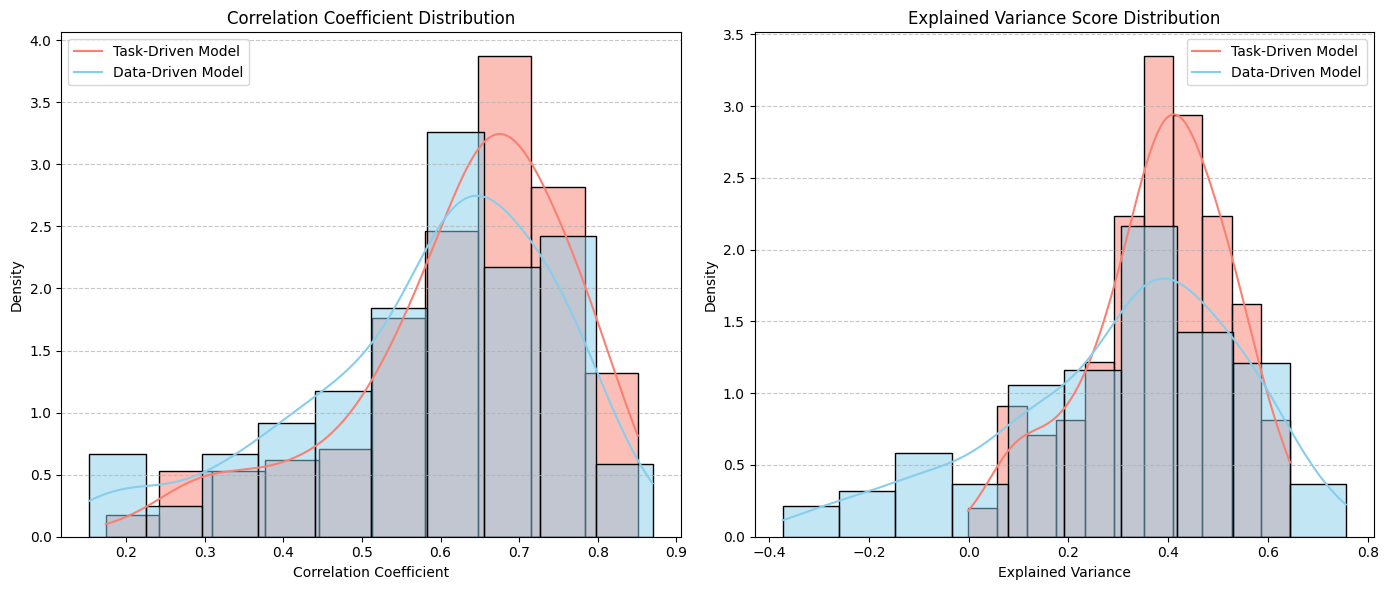

Mean correlation (Data-Driven): 0.5876, Std: 0.1598
MSE (Data-Driven): 0.0834
Mean explained variance (Data-Driven): 0.3057, Std: 0.2396


In [35]:
# Compute metrics for task-driven model
lin_reg_results_task_driven = {'corr': {}, 'mse': {}, 'EV': {}}
lin_reg_results_task_driven['corr'] = correlation_task_driven
lin_reg_results_task_driven['mse'] = mse_task_driven
lin_reg_results_task_driven['EV'] = explained_variance_task_driven

# Compute metrics for best model
lin_reg_results_best = {'corr': {}, 'mse': {}, 'EV': {}}
lin_reg_results_best['corr'] = correlation_best
lin_reg_results_best['mse'] = mse_best
lin_reg_results_best['EV'] = explained_variance_best

# Prepare correlation data
r_vals_task = lin_reg_results_task_driven['corr'].statistic
p_vals_task = lin_reg_results_task_driven['corr'].pvalue
confident_r_vals_task = r_vals_task[p_vals_task < 0.05]

r_vals_best = lin_reg_results_best['corr'].statistic
p_vals_best = lin_reg_results_best['corr'].pvalue
confident_r_vals_best = r_vals_best[p_vals_best < 0.05]

# Plot both histograms as subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: Correlation Coefficients ---
sns.histplot(confident_r_vals_task, bins=10, kde=True, stat='density', color='salmon', ax=axs[0])
sns.histplot(confident_r_vals_best, bins=10, kde=True, stat='density', color='skyblue', ax=axs[0])
axs[0].set_title('Correlation Coefficient Distribution')
axs[0].set_xlabel('Correlation Coefficient')
axs[0].set_ylabel('Density')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].legend(['Task-Driven Model', 'Data-Driven Model'])

# --- Subplot 2: Explained Variance ---
sns.histplot(lin_reg_results_task_driven['EV'], kde=True, stat='density', color='salmon', ax=axs[1])
sns.histplot(lin_reg_results_best['EV'], kde=True, stat='density', color='skyblue', ax=axs[1])
axs[1].set_title('Explained Variance Score Distribution')
axs[1].set_xlabel('Explained Variance')
axs[1].set_ylabel('Density')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].legend(['Task-Driven Model', 'Data-Driven Model'])

plt.tight_layout()
plt.show()

# Print stats
print(f"Mean correlation (Data-Driven): {np.mean(confident_r_vals_best):.4f}, Std: {np.std(confident_r_vals_best):.4f}")
print(f"MSE (Data-Driven): {lin_reg_results_best['mse']:.4f}")
print(f"Mean explained variance (Data-Driven): {np.mean(lin_reg_results_best['EV']):.4f}, Std: {np.std(lin_reg_results_best['EV']):.4f}")


### Fitting a MLP between activations and spikes

In [38]:
# Use a mlp to fit activations to spikes
model_mlp = torch.nn.Sequential(
    torch.nn.Linear(X_train.shape[1], 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, y_train.shape[1])
)

#model_mlp = model_mlp.to('cuda')
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

num_epochs = 1000
for epoch in range(num_epochs):
    model_mlp.train()
    optimizer.zero_grad()
    outputs = model_mlp(torch.tensor(X_train).float())#.to('cuda'))
    loss = criterion(outputs, torch.tensor(y_train).float())#.to('cuda'))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        
# Evaluate the model on the validation set
model_mlp.eval()
with torch.no_grad():
    y_pred_mlp = model_mlp(torch.tensor(X_val).float())#.to('cuda')).cpu().numpy()
    y_pred_mlp = np.clip(y_pred_mlp, 0, None)  # Clip negative values to zero

C:\Users\charl\AppData\Local\Temp\ipykernel_6628\1629792374.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model_mlp(torch.tensor(X_train).float())#.to('cuda'))


Epoch [100/1000], Loss: 0.0750
Epoch [200/1000], Loss: 0.0564
Epoch [300/1000], Loss: 0.0495
Epoch [400/1000], Loss: 0.0441
Epoch [500/1000], Loss: 0.0418
Epoch [600/1000], Loss: 0.0397
Epoch [700/1000], Loss: 0.0395
Epoch [800/1000], Loss: 0.0379
Epoch [900/1000], Loss: 0.0374
Epoch [1000/1000], Loss: 0.0370


In [41]:
# Calculate the pearson correlation and explained variance score between each neuron
correlation_best_mlp = pearsonr(spikes_val, y_pred_mlp)
explained_variance_best_mlp = explained_variance_score(spikes_val, y_pred_val,  multioutput='raw_values')
mse_best_mlp = mean_squared_error(spikes_val, y_pred_val)

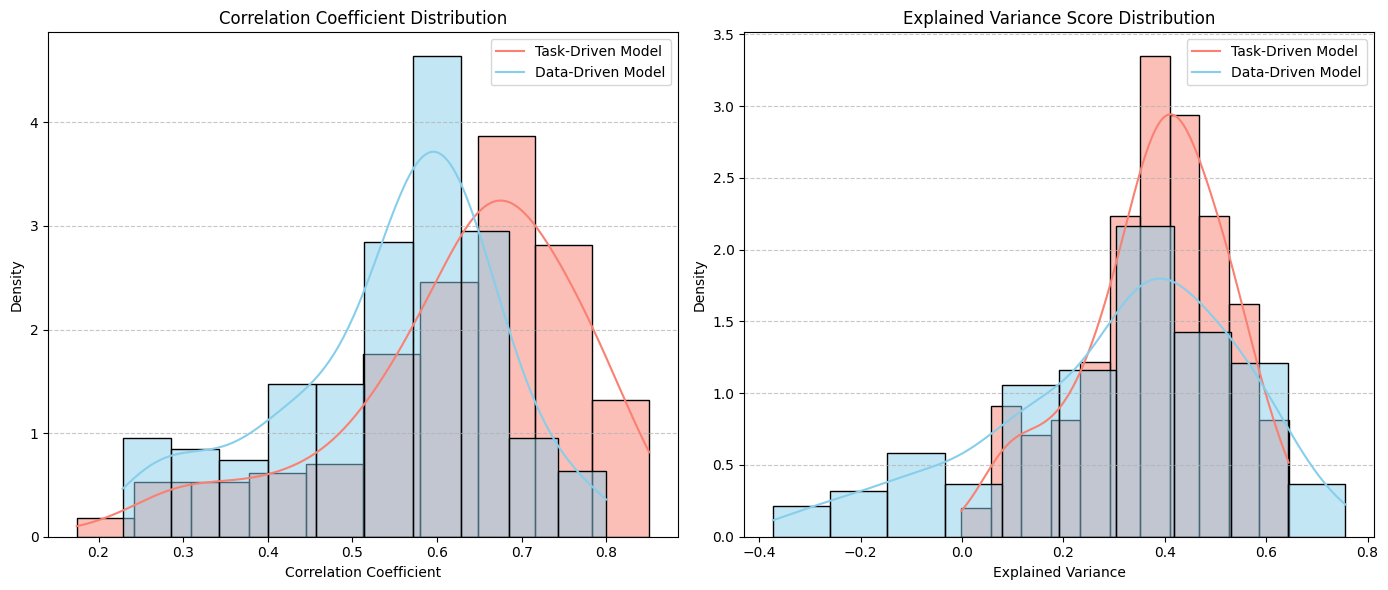

Mean correlation (Data-Driven): 0.5458, Std: 0.1268
MSE (Data-Driven): 0.0834
Mean explained variance (Data-Driven): 0.3057, Std: 0.2396


In [42]:
# Compute metrics for best model
lin_reg_results_best_mlp = {'corr': {}, 'mse': {}, 'EV': {}}
lin_reg_results_best_mlp['corr'] = correlation_best_mlp
lin_reg_results_best_mlp['mse'] = mse_best_mlp
lin_reg_results_best_mlp['EV'] = explained_variance_best_mlp

# Prepare correlation data
r_vals_task = lin_reg_results_task_driven['corr'].statistic
p_vals_task = lin_reg_results_task_driven['corr'].pvalue
confident_r_vals_task = r_vals_task[p_vals_task < 0.05]

r_vals_best_mlp = lin_reg_results_best_mlp['corr'].statistic
p_vals_best_mlp = lin_reg_results_best_mlp['corr'].pvalue
confident_r_vals_best_mlp = r_vals_best_mlp[p_vals_best_mlp < 0.05]

# Plot both histograms as subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Subplot 1: Correlation Coefficients ---
sns.histplot(confident_r_vals_task, bins=10, kde=True, stat='density', color='salmon', ax=axs[0])
sns.histplot(confident_r_vals_best_mlp, bins=10, kde=True, stat='density', color='skyblue', ax=axs[0])
axs[0].set_title('Correlation Coefficient Distribution')
axs[0].set_xlabel('Correlation Coefficient')
axs[0].set_ylabel('Density')
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].legend(['Task-Driven Model', 'Data-Driven Model'])

# --- Subplot 2: Explained Variance ---
sns.histplot(lin_reg_results_task_driven['EV'], kde=True, stat='density', color='salmon', ax=axs[1])
sns.histplot(lin_reg_results_best_mlp['EV'], kde=True, stat='density', color='skyblue', ax=axs[1])
axs[1].set_title('Explained Variance Score Distribution')
axs[1].set_xlabel('Explained Variance')
axs[1].set_ylabel('Density')
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].legend(['Task-Driven Model', 'Data-Driven Model'])

plt.tight_layout()
plt.show()

# Print stats
print(f"Mean correlation (Data-Driven): {np.mean(confident_r_vals_best_mlp):.4f}, Std: {np.std(confident_r_vals_best_mlp):.4f}")
print(f"MSE (Data-Driven): {lin_reg_results_best_mlp['mse']:.4f}")
print(f"Mean explained variance (Data-Driven): {np.mean(lin_reg_results_best_mlp['EV']):.4f}, Std: {np.std(lin_reg_results_best_mlp['EV']):.4f}")

We see that our MLP head doesn't improve the scores.